# DL и последовательные данные

Для анализа последовательных данных — звука, музыки, текста, температуры в Мюнхене, изменения цены биткоина, спортивной статистики, шахматных ходов, состояний игры в Доте — используются свои архитектуры.

## Рекуррентные сети



![RNN](https://i.stack.imgur.com/hzZ4m.png)

На уровне псевдокода, оно выглядит так:

In [ ]:
h = 0
for x in sequence:
    h =  f(x, h)

Давайте рассмотрим игрушечный пример — научим сеть предсказывать что-то шумное, изменяющееся по синусоиде. В Keras есть слой SimpleRNN, который делает примерно то же, что и этот псевдокод, только в качестве f мы выбираем матричное умножение и произвольную функцию активации.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

Так как фреймворки из-за реализационных особенностей работают с батчами, а не единичными примерами, то входные данные должны иметь форму (размер_батча, длина, число фичей на вход). Заметьте, что длина у всех сэмплов должна быть одинакова. Если это не так, то короткие последовательности следует дополнить каким-нибудь пустым токеном.

На практике пайплайн такой:

* Токенизировать данные
* Сконвертировать в вектора
* Пропустить через алгоритм, который вернет тоже вектора
* Сконвертировать обратно (если мы генерируем тоже текст)

Это не сложно, но это все не относится к DL.

In [47]:
from keras.datasets import imdb
from keras.preprocessing import sequence

vocab_size = 10000
embedding_dim = 50

(X, y), _ = imdb.load_data(num_words=vocab_size)

Что происходит со словами, которые не вошли в топ самых популярых? Они все заменяются на специальный токен <UNK>.

467.0


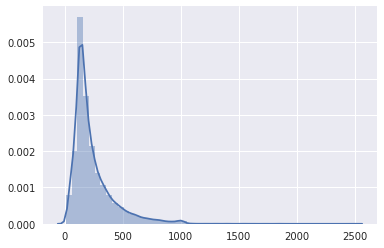

In [48]:
lens = [len(x) for x in X]
sns.distplot(lens)
print(np.percentile(lens, 90))

Нам нужно ограничить размеры примеров. Выберем в качестве этого параметра что-то около 500. Это покроет более 90% примеров.

In [49]:
maxlen = 500
X = sequence.pad_sequences(X, maxlen=maxlen)

In [50]:
from keras.layers import SimpleRNN, Dense, Embedding
from keras.models import Sequential

RNN = Sequential([
    Embedding(vocab_size, embedding_dim),
    SimpleRNN(embedding_dim),
    Dense(1, activation='sigmoid')
])

RNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 50)          500000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 505,101
Trainable params: 505,101
Non-trainable params: 0
_________________________________________________________________


In [56]:
RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = RNN.fit(X, y, epochs=5, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 71s - loss: 0.6034 - acc: 0.6711 - val_loss: 0.5733 - val_acc: 0.6872
Epoch 2/5
22500/22500 [==============================] - 76s - loss: 0.4686 - acc: 0.7772 - val_loss: 0.4891 - val_acc: 0.7688
Epoch 3/5
22500/22500 [==============================] - 76s - loss: 0.4624 - acc: 0.7811 - val_loss: 0.4867 - val_acc: 0.7716.781
Epoch 4/5
22500/22500 [==============================] - 75s - loss: 0.3571 - acc: 0.8462 - val_loss: 0.6198 - val_acc: 0.7232
Epoch 5/5
22500/22500 [==============================] - 66s - loss: 0.2628 - acc: 0.8928 - val_loss: 0.5777 - val_acc: 0.7788


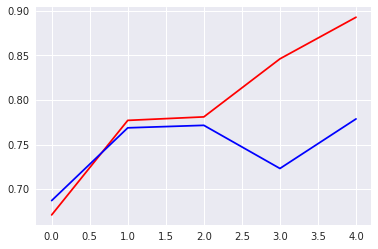

In [57]:
plt.plot(history.history['acc'], c='r')
plt.plot(history.history['val_acc'], c='b')

## Представление текста

Как и всегда, нейросети не берут на вход сырые текстовые данные. Как правило текст разделяют (или *токенизируют*) на мелкие куски (буквы, слова, отдельные частые сочетания букв — BPE). Дальше каждый с каждым таким токеном ассоциируется его векторное представление — embedding, которое подается на вход рекуррентной сети.

## One-hot и embedding

Самый простой способ ассоциировать с каждым токеном свой вектор — дать каждому.

По сути, one-hot с последовательным применением матрицы эквивалентен embedding-у с самого начала, но дольше.

В выходных данных мы пока не придумали ничего лучше, чем one-hot.

Они имеют скрытое состояние — какой-то вектор $h$. Они обрабатывают данные последовательно каждый раз принимая на вход какое-то новое значение.

Сеть принимает теперь два входа: обновление состоянияи свое скрытое состояние с предыдущего шага.

teacher forcing — это когда мы даем на вход правильный символ а не тот, который мы предсказали.

# Генерация текстов

Домашним заданием будет сделать генерацию музыки (<-- это вообще можно сделать без LSTM?).

# Как на самом деле работают RNN

В рекуррентных сетях центральная проблема — затухающий градиент. С ней борятся с помощью механизма памяти.

# Long-short Term Memory

Представьте конвейерную ленту, которая движется вдоль наших последовательных данных. Информация с данных может запрыгивать на ленту, проезжать вперед и спрыгивать оттуда, когда она понадобится. Примерно так работает LSTM: он сохраняет информацию для более позднего времени, когда она понадобится.

Используется она точно так же, как и SimpleRNN, только внутри устроена иначе.

**Задание**. Запустите код предыдущего примера с LSTM и GRU и посмотрите разницу в качестве.

![LSTM](https://cdn-images-1.medium.com/max/2000/1*S0Y1A3KXYO7_eSug_KsK-Q.png)

Осуществляется это так: есть два типа памяти, долгосрочная и короткосрочная. Последняя используется для того, чтобы выбрать, что нам интересно во входных данных.

# Attention

С 2017 года в самом передовом нейросетевом NLP почти всегда используется в каком-то виде механизм attention (англ. «внимание»).

В Google даже сделали сеть для перевода («Transformer»), которая не использует каких-либо скрытых состояний, которая сейчас считается лучшей в мире (см. Attention is All You Need).

Его можно рассмотреть как базу данных: у нас есть какие-то данные (векторизованные, одного размера), у них есть ключи, и нам по запросу нужно эти данные вернуть.

# Трюки и хаки

Если у нас мало данных, то word2vec можно заморозить.

LSTM и GRU можно сделать двусторонними. В Keras это делается просто: